<a href="https://colab.research.google.com/github/mapzine123/machine-running/blob/main/4_%EB%8B%A4%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 신경망 알고리즘을 벡터화하기

넘파이, 머신러닝, 딥러닝 패키지는 다차원 배열(행렬) 계산을 빨리 할 수 있음  
이런 기능을 `벡터화(vectorization)된 연산`이라고 표현함  
벡터화된 연산을 사용하면 알고리즘의 성능을 높일 수 있음


### 배치 경사 하강법
알고리즘을 1번 반복할 때 1개의 샘플을 사용하는 경사하강법을 `확률적 경사 하강법`이라고 함 (지금까지 이걸로 실습함)  
이 방법은 가중치를 1번 업데이트할 때 1개의 샘플을 사용해 손실 함수의 전역 최솟값을 불안정하게 찾음  

배치 경사 하강법은 가중치를 1번 업데이트 할 때 전체 샘플을 사용함  
그래서 손실 함수의 전역 최솟값을 안정적으로 찾음  
대신, 1번 업데이트할 때 사용되는 데이터 개수가 많아 1번 수행당 계산 비용이 많이 듬

### 행렬 곱셈 표현


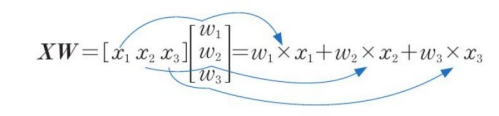

In [ ]:
# 행렬 곱 표현
# z = np.dot(x, self.w) + self.b

# 실습

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m
    b_grad = np.sum(err) / m
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.w = np.ones((x.shape[1], 1))
    self.b = 0
    self.w_history.append(self.w.copy())

    for i in range(epochs):
      z = self.forpass(x)
      a = self.activation(z)
      err = -(y - a)
      w_grad, b_grad = self.backprop(x, err)
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad

      self.w_history.append(self.w.copy())
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y) * np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1, 1))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

## 훈련 데이터 표준화 전처리

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)       # 변환 규칙 익히기
x_train_scaled = scaler.transform(x_train) # 훈련세트 데이터 표준화 전처리
x_val_scaled = scaler.transform(x_val)     # 검증세트 데이터 표준화 전처리

## SingleLayer에 전달해 배치 경사 하강법 적용

In [ ]:
layer = SingleLayer(l2=0.01)
layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
layer.score(x_val_scaled, y_val)

0.978021978021978

## 검증 세트로 성능 측정 후 그래프로 비교

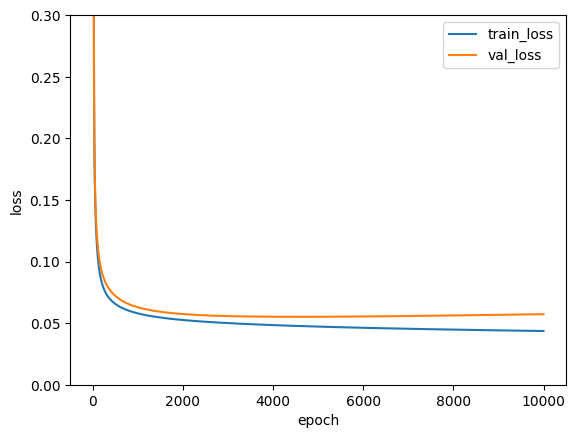

In [ ]:
plt.ylim(0, 0.3)
plt.plot(layer.losses)
plt.plot(layer.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

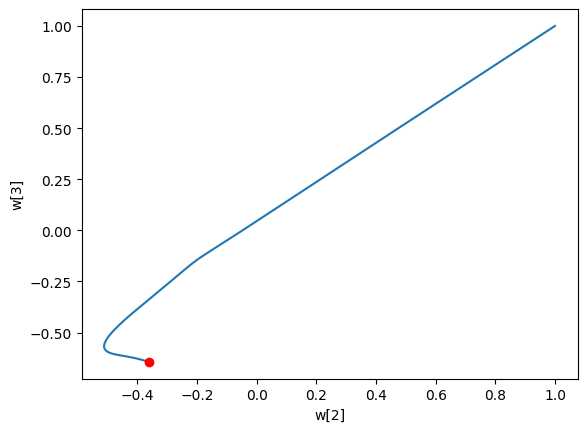

In [ ]:
w2 = []
w3 = []
for w in layer.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

## 2개의 층을 가진 신경망

### 하나의 층에 여러개의 뉴런을 사용


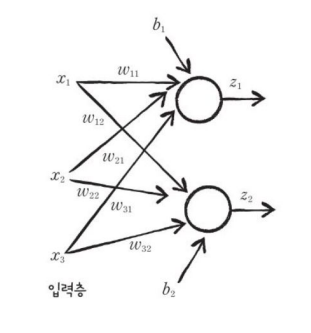

3개의 특성과 2개의 뉴런이 있는 경우  

입력값이 나열된 부분을 '입력층'이라고 표현  

3개의 특성은 각각 2개의 뉴런에 모두 전달되 z1, z2를 출력함